# Bayesian Logistic Regression
[Bayesian logistic regression](https://en.wikipedia.org/wiki/Logistic_regression#Bayesian) is the Bayesian counterpart to a common tool in machine learning, logistic regression. The goal of logistic regression is to predict a one or a zero for a given training item. An example might be predicting whether someone is sick or ill given their symptoms and personal information.

In our example, we'll be working to predict whether someone is likely to default with a synthetic dataset found in the `RDatasets` package. This dataset, `Defaults`, comes from R's [ISLR](https://cran.r-project.org/web/packages/ISLR/index.html) package and contains information on borrowers.

To start, let's import all the libraries we'll need.

In [1]:
# Import Turing and Distributions.
using Turing, Distributions

# Import RDatasets.
using RDatasets

# Import MCMCChains, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# We need a logistic function, which is provided by StatsFuns.
using StatsFuns: logistic

# Set a seed for reproducibility.
using Random
Random.seed!(0);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing C:\Users\ngudat\.julia\packages\Turing\eIa7P\src\Turing.jl:24


false

## Data Cleaning & Set Up

Now we're going to import our dataset. The first six rows of the dataset are shown below so you can get a good feel for what kind of data we have.

In [2]:
# Import the "Default" dataset.
data = RDatasets.dataset("ISLR", "Default");

# Show the first six rows of the dataset.
first(data, 6)

,Default,Student,Balance,Income
,Categorical…,Categorical…,Float64,Float64
1,No,No,729.526,44361.6
2,No,Yes,817.18,12106.1
3,No,No,1073.55,31767.1
4,No,No,529.251,35704.5
5,No,No,785.656,38463.5
6,No,Yes,919.589,7491.56


Most machine learning processes require some effort to tidy the data, and this one is no different. We need to convert the `Default` and `Student` columns, which are coded as "Yes" or "No", into 1s and 0s. Afterwards, we'll get rid of the old words-based columns.

In [3]:
# Create new rows set to zero for all rows
data[!, :DefaultNum] .= 0.0
data[!, :StudentNum] .= 0.0

# Change 0s to 1s where default or student is "Yes"
data[data.Default .== "Yes", :DefaultNum] .= 1.0
data[data.Student .== "Yes", :StudentNum] .= 1.0

# Delete the old columns which say "Yes" and "No".
select!(data, Not([:Default, :Student]))

# Show the first six rows of our edited dataset.
first(data, 6)

,Balance,Income,DefaultNum,StudentNum
,Float64,Float64,Float64,Float64
1,729.526,44361.6,0.0,0.0
2,817.18,12106.1,0.0,1.0
3,1073.55,31767.1,0.0,0.0
4,529.251,35704.5,0.0,0.0
5,785.656,38463.5,0.0,0.0
6,919.589,7491.56,0.0,1.0


After we've done that tidying, it's time to split our dataset into training and testing sets, and separate the labels from the data. We separate our data into two halves, `train` and `test`. You can use a higher percentage of splitting (or a lower one) by modifying the `at = 0.05` argument. We have highlighted the use of only a 5% sample to show the power of Bayesian inference with small sample sizes.

In [4]:
# Function to split samples.
function split_data(df, at = 0.70)
    r = size(df, 1)
    index = Int(round(r * at))
    train = df[1:index, :]
    test  = df[(index+1):end, :]
    return train, test
end

# Split our dataset 5/95 into training/test sets.
train, test = split_data(data, 0.05);

# Create our labels. These are the values we are trying to predict.
train_label = train.DefaultNum
test_label = test.DefaultNum

# Remove the columns that are not our predictors.
train = train[:, [:StudentNum, :Balance, :Income]];
test = test[:, [:StudentNum, :Balance, :Income]];

Our `train` and `test` matrices are still in the `DataFrame` format, which tends not to play too well with the kind of manipulations we're about to do, so we convert them into `Matrix` objects.

In [5]:
# Convert the DataFrame objects to matrices.
train = Matrix(train);
test = Matrix(test);

This next part is critically important. We must rescale our variables so that they are centered around zero by subtracting each column by the mean and dividing it by the standard deviation. Without this step, Turing's sampler will have a hard time finding a place to start searching for parameter estimates.

In [6]:
# Rescale our matrices using MLDataUtils rescale! function
train = (train .- mean(train, dims=1)) ./ std(train, dims=1)
test = (test .- mean(test, dims=1)) ./ std(test, dims=1);

## Model Declaration 
Finally, we can define our model.

`logistic_regression` takes four arguments:

- `x` is our set of independent variables;
- `y` is the element we want to predict;
- `n` is the number of observations we have; and
- `σ` is the standard deviation we want to assume for our priors.

Within the model, we create four coefficients (`intercept`, `student`, `balance`, and `income`) and assign priors of Normal distributions with zero mean and `σ` standard deviation. We want to find values of these four coefficients to predict any given `y`.

The `for` block creates a variable `v` which is the output of the logistic function applied to the values of our observations and coefficients. We then observe the liklihood of calculating `v` given the actual label, `y[i]`.

In [7]:
# Bayesian logistic regression (LR)
@model logistic_regression(x, y, n, σ) = begin
    intercept ~ Normal(0, σ)

    student ~ Normal(0, σ)
    balance ~ Normal(0, σ)
    income  ~ Normal(0, σ)

    for i = 1:n
        v = logistic(intercept + student*x[i, 1] + balance*x[i,2] + income*x[i,3])
        y[i] ~ Bernoulli(v)
    end
end;

## Sampling

Now we can run our sampler. This time we'll use [`HMC`](http://turing.ml/docs/library/#Turing.HMC) to sample from our posterior.

In [8]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Retrieve the number of observations.
n = size(train, 1)

# Sample using HMC.
chain = mapreduce(c -> sample(logistic_regression(train, train_label, n, 1), HMC(1500, 0.05, 10)),
    chainscat,
    1:3
)

describe(chain)

┌ Info: Finished 1500 sampling steps in 0.612900999 (s)
│   h = Hamiltonian(metric=UnitEuclideanMetric([1.0, 1.0, 1.0, 1.0]))
│   τ = StaticTrajectory(integrator=Leapfrog(ϵ=0.05), λ=10))
│   EBFMI_est = 706.8134708118461
│   average_acceptance_rate = 0.9927312040618189
└ @ AdvancedHMC C:\Users\ngudat\.julia\packages\AdvancedHMC\g9AcH\src\sampler.jl:137
┌ Info: Finished 1500 sampling steps in 0.501036901 (s)
│   h = Hamiltonian(metric=UnitEuclideanMetric([1.0, 1.0, 1.0, 1.0]))
│   τ = StaticTrajectory(integrator=Leapfrog(ϵ=0.05), λ=10))
│   EBFMI_est = 462.74449024900485
│   average_acceptance_rate = 0.9924254968782502
└ @ AdvancedHMC C:\Users\ngudat\.julia\packages\AdvancedHMC\g9AcH\src\sampler.jl:137
┌ Info: Finished 1500 sampling steps in 0.690017401 (s)
│   h = Hamiltonian(metric=UnitEuclideanMetric([1.0, 1.0, 1.0, 1.0]))
│   τ = StaticTrajectory(integrator=Leapfrog(ϵ=0.05), λ=10))
│   EBFMI_est = 560.1562208987289
│   average_acceptance_rate = 0.99290590318805
└ @ AdvancedHMC C:\Us

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean       │ std      │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64    │ Float64  │ Float64    │ Float64    │ Any     │
├─────┼────────────┼────────────┼──────────┼────────────┼────────────┼─────────┤
│ 1   │ balance    │ 1.68832    │ 0.307869 │ 0.00458944 │ 0.0074077  │ 277.649 │
│ 2   │ income     │ -0.0303271 │ 0.36888  │ 0.00549894 │ 0.00921239 │ 1609.74 │
│ 3   │ intercept  │ -4.38323   │ 0.493617 │ 0.0073584  │ 0.014967   │ 78.042  │
│ 4   │ student    │ -0.275031  │ 0.366617 │ 0.00546521 │ 0.0106826  │ 1360.64 │

Quantiles

│ Row │ parameters │ 2.5%      │ 25.0%     │ 50.0%      │ 75.0%     │ 97.5%    │
│     │ Symbol     │ Float64   │ Float64   │ Float64    │ Float64   │ Float64  │
├─────┼────────────┼───────────┼───────────┼────────────┼───────────┼──────────┤
│ 1   │ balance    │ 1.14033   │ 1.4896    │ 1.68138    │ 1.87725   │ 2.28083  │
│ 2   │ inc

Since we ran multiple chains, we may as well do a spot check to make sure each chain converges around similar points.

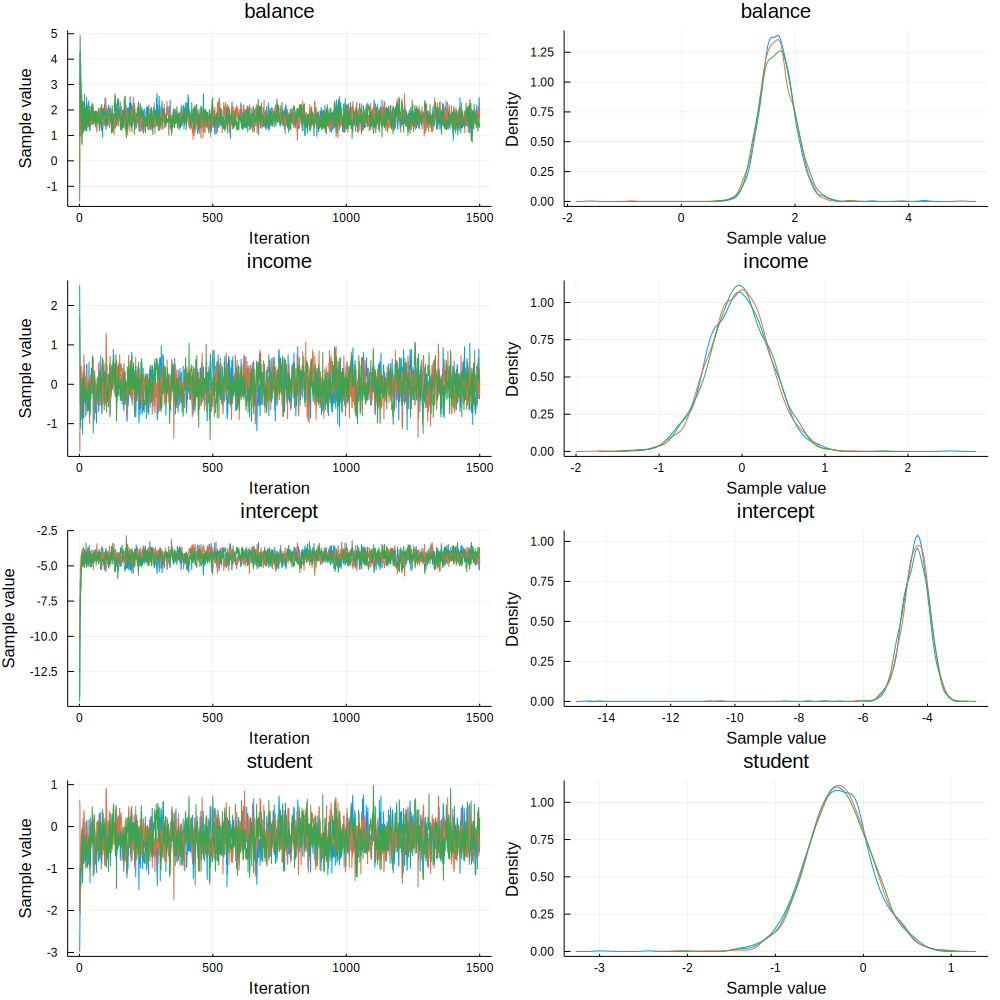

In [9]:
plot(chain)

Looks good!

We can also use the `corner` function from MCMCChains to show the distributions of the various parameters of our logistic regression. 

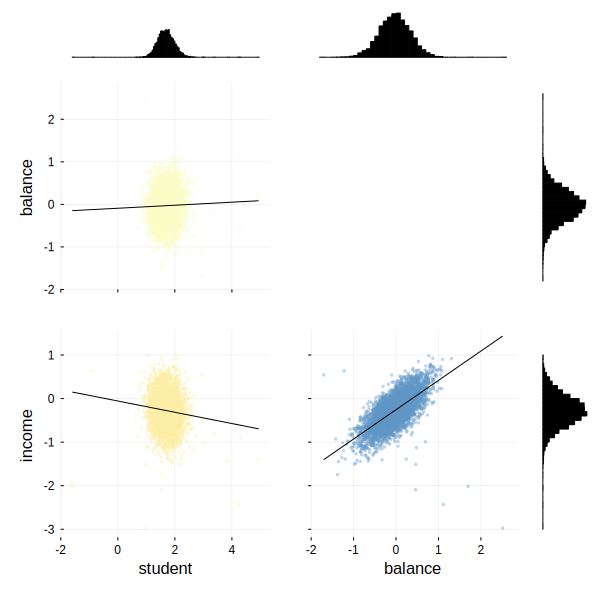

In [10]:
# Use the corner function for our labels of interest. Requires StatsPlots and MCMCChain.
corner(chain, [:student, :balance, :income])

Fortunately the corner plot appears to demonstrate unimodal distributions for each of our parameters, so it should be straightforward to take the means of each parameter's sampled values to estimate our model to make predictions.

## Making Predictions
How do we test how well the model actually predicts whether someone is likely to default? We need to build a prediction function that takes the `test` object we made earlier and runs it through the average parameter calculated during sampling.

The `prediction` function below takes a `Matrix` and a `Chain` object. It takes the mean of each parameter's sampled values and re-runs the logistic function using those mean values for every element in the test set.

In [11]:
function prediction(x::Matrix, chain, threshold)
    # Pull the means from each parameter's sampled values in the chain.
    intercept = mean(chain[:intercept].value)
    student = mean(chain[:student].value)
    balance = mean(chain[:balance].value)
    income = mean(chain[:income].value)

    # Retrieve the number of rows.
    n = size(x, 1)

    # Generate a vector to store our predictions.
    v = zeros(n)

    # Calculate the logistic function for each element in the test set and compare to threshold.
    for (i, r) ∈ enumerate(eachrow(x))
        num = logistic(intercept + student * r[1] + balance * r[2] + income * r[3])
        v[i] = num >= threshold ? 1 : 0
    end
    return v
end;

Let's see how we did! We run the test matrix through the prediction function, and compute the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE) for our prediction. The `threshold` variable sets the sensitivity of the predictions. For example, a threshold of 0.10 will predict a default value of 1 for any predicted value greater than 0.1 and no default if the predicted value is less than 0.1.

In [12]:
# Set the prediction threshold.
threshold = 0.10

# Make the predictions.
predictions = prediction(test, chain, threshold)

# Calculate MSE for our test set.
loss = sum((predictions - test_label).^2) / length(test_label)

0.08242105263157895

Perhaps more important is to see what percentage of defaults we correctly predicted. The code below simply counts defaults and predictions and presents the results. 

In [13]:
defaults = sum(test_label)
not_defaults = length(test_label) - defaults

predicted_defaults = sum(test_label .== predictions .== 1)
predicted_not_defaults = sum(test_label .== predictions .== 0)

println("Defaults: $defaults
    Predictions: $predicted_defaults
    Percentage defaults correct $(predicted_defaults/defaults)")

println("Not defaults: $not_defaults
    Predictions: $predicted_not_defaults
    Percentage non-defaults correct $(predicted_not_defaults/not_defaults)")

Defaults: 317.0
    Predictions: 247
    Percentage defaults correct 0.7791798107255521
Not defaults: 9183.0
    Predictions: 8470
    Percentage non-defaults correct 0.9223565283676358


The above shows that with a threshold of 0.10, we correctly predict a respectable portion of the defaults, and correctly identify most non-defaults. This is fairly sensitive to a choice of threshold, and you may wish to experiment with it.

This tutorial has demonstrated how to use Turing to perform Bayesian logistic regression. 